## Table des Matières

#### 0. Imports utiles (librairies et fonctions du cours utilisés)

#### I. Introduction

#### II. Data overview

#### III. Sentiment analys

#### IV. Sentiment and Market fluctuation

#### V.Conclusion and limits

0.  Imports utiles (librairies et fonctions du cours utilisées pour la réplication)

In [693]:
# Installation de nouveaux modules 

#!pip install pdfminer.six
#!pip install tqdm
#!pip install yfinance
#!pip install PyPDF2

In [694]:
# Importation des modules utilisés

import pdfminer
import pdfminer.high_level
import requests
from PyPDF2 import PdfFileReader
from pdfminer.high_level import extract_text_to_fp
from pdfminer.layout import LAParams
from io import StringIO, BytesIO

import logging
import os
import re
import subprocess
import sys
import warnings
from zipfile import ZipFile

import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tqdm.auto import tqdm
from datetime import datetime
from tqdm import tqdm
import string

from sklearn.decomposition import NMF, PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, ElasticNetCV

import matplotlib.pyplot as plt
from matplotlib import cm

from IPython.display import HTML, display

from pathlib import Path
from pandas.tseries.offsets import BDay

import yfinance as yf

In [695]:
# Fonctions du cours de Sylvain Champonnois utilisées (Source: https://github.com/schampon/skfin)

def bar(
    df,
    err=None,
    sort=True,
    figsize=(8, 5),
    ax=None,
    title=None,
    horizontal=False,
    baseline=None,
    rotation=0,
):
    if isinstance(df, pd.DataFrame):
        df = df.squeeze()
    if isinstance(df, dict):
        df = pd.Series(df)
    if sort:
        df = df.sort_values()
    if err is not None:
        err = err.loc[df.index]
    labels = df.index
    x = np.arange(len(labels))
    fig, ax = set_axis(ax=ax, figsize=figsize, title=title)
    if horizontal:
        ax.barh(x, df.values, xerr=err, capsize=5)
        ax.set_yticks(x)
        ax.set_yticklabels(labels, rotation=0)
        if baseline in df.index:
            df_ = df.copy()
            df_[df.index != baseline] = 0
            ax.barh(x, df_.values, color="lightgreen")
    else:
        ax.bar(x, df.values, yerr=err, capsize=5)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=0)
        if baseline in df.index:
            df_ = df.copy()
            df_[df.index != baseline] = 0
            ax.bar(x, df_.values, color="lightgreen")
    ax.set_title(title)

def load_loughran_mcdonald_dictionary():
    """
    Software Repository for Accounting and Finance by Bill McDonald
    https://sraf.nd.edu/loughranmcdonald-master-dictionary/
    """
    print("loading from external source")
    id = "17CmUZM9hGUdGYjCXcjQLyybjTrcjrhik"
    url = f"https://docs.google.com/uc?export=download&id={id}"
    response = requests.get(url, stream=True)

    dictionary_data = BytesIO(response.content)
    return pd.read_csv(dictionary_data)

In [696]:
plt.style.use("seaborn-v0_8-whitegrid")


def set_axis(ax=None, figsize=(8, 5), title=None, fig=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    if title is not None:
        ax.set_title(title)
    return fig, ax


def line(
    df,
    sort=True,
    figsize=(8, 5),
    ax=None,
    title="",
    cumsum=False,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    legend_sharpe_ratio=None,
    legend=True,
    yscale=None,
    start_date=None,
):
    df = df.copy()
    if loc == "best":
        bbox_to_anchor = None
    if isinstance(df, dict) | isinstance(df, list):
        df = pd.concat(df, axis=1)
    if isinstance(df, pd.Series):
        df = df.to_frame()
    if start_date is not None:
        df = df[start_date:]
    if cumsum & (legend_sharpe_ratio is None):
        legend_sharpe_ratio = True
    if legend_sharpe_ratio:
        df.columns = [f"{c}: sr={sharpe_ratio(df[c]): 3.2f}" for c in df.columns]
    if cumsum:
        df = df.cumsum()
    if sort:
        df = df.loc[:, lambda x: x.iloc[-1].sort_values(ascending=False).index]
    fig, ax = set_axis(ax=ax, figsize=figsize, title=title)
    ax.plot(df.index, df.values)
    if legend:
        ax.legend(df.columns, loc=loc, bbox_to_anchor=bbox_to_anchor)
    if yscale == "log":
        ax.set_yscale("log")

In [697]:

def show_text(df, lexica=None, text_column="Text", n=2):
    if n is not None:
        df = df.sample(n=n)
    df = df.assign(
        **{
            text_column: lambda x: x[text_column]
            .str.replace("$", "\$", regex=False)
            .str.replace("\n", " ", regex=False)
        }
    )
    if lexica is not None:
        df = df.assign(
            **{
                text_column: lambda x: x[text_column].apply(
                    highlight_lexica, lexica=lexica
                )
            }
        )
    display(HTML(df.to_html(escape=False)))


green_text = lambda x: f"<b><font color = green>{x}</font></b>"
red_text = lambda x: f"<b><font color = red>{x}</font></b>"


def color_text(x, lexica):
    if x.lower() in lexica["positive"]:
        return green_text(x)
    elif x.lower() in lexica["negative"]:
        return red_text(x)
    else:
        return x


def highlight_lexica(string, lexica):
    if isinstance(string, list):
        string = string[0]
    string = string.replace("<br /><br />", "")
    return " ".join([color_text(x, lexica) for x in string.split(" ")])


In [698]:
def coefs_plot(coef, n=40, fontsize=12, rotation=0, title=None, filename=None):
    """
    plot the coefficients from a  tfidf+linear_model pipeline on words (with positive and negative values)
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 10))
    df_pos = coef.squeeze().loc[lambda x: x > 0].sort_values().tail(n)
    labels = df_pos.index
    x = np.arange(len(labels))
    ax[1].barh(x, df_pos.values, capsize=5)
    ax[1].set_yticks(x)
    ax[1].set_yticklabels(labels, rotation=rotation, fontsize=fontsize)
    ax[1].yaxis.tick_right()
    ax[1].set_title("positive coefficients")

    df_neg = coef.squeeze().loc[lambda x: x < 0].sort_values(ascending=False).tail(n)
    labels = df_neg.index
    x = np.arange(len(labels))
    ax[0].barh(x, df_neg.values, capsize=5)
    ax[0].set_yticks(x)
    ax[0].set_yticklabels(labels, rotation=rotation, fontsize=fontsize)
    ax[0].set_title("negative coefficients")
    if title is not None:
        fig.suptitle(title, y=0.92)
    if filename is not None:
        plt.savefig(
            str(filename) + ".png", orientation="landscape", bbox_inches="tight"
        )

## I. Introduction

### B. Données utilisées

In [699]:
def get_boj_statements_urls(from_year=1999, switch_year=None):
    """
    Retrieves URLs for Bank of Japan (BOJ) monetary policy statements and decisions.

    This function scrapes the BOJ website for given years, extracting URLs for documents related to monetary policy decisions, which can be either in HTML or PDF format. Each document's publication date is extracted from its URL and paired with the full URL.

    Returns:
    - DataFrame: A pandas DataFrame with two columns, 'Date' and 'URL', where 'Date' is the publication date of the document , and 'URL' is the full URL to the document.
    """

    if switch_year is None:
        switch_year = datetime.now().year

    urls_ = []  
    date_url_pairs = []

    # Wrap the year range with tqdm for a progress bar
    for year in tqdm(range(from_year, switch_year + 1), desc="Processing years"):
        stat_yearly_url = f"https://www.boj.or.jp/en/mopo/mpmdeci/state_{year}/index.htm"
        r_year = requests.get(stat_yearly_url)
        if r_year.status_code == 200:
            soup_yearly = BeautifulSoup(r_year.text, "html.parser")
            yearly_contents = soup_yearly.find_all("a", href=re.compile("^/en/mopo/mpmdeci/(state_|mpr_)\d{4}/k\d{6}(a|x)?\.(htm|pdf)"))
            
            for yearly_content in yearly_contents:
                href = yearly_content.attrs["href"]
                urls_.append(href)
                # Extract date from the href and add it to the list
                match = re.search(r'k(\d{6})(a|x)?\.(htm|pdf)$', href)
                if match:
                    date_str = match.group(1)
                    date_url_pairs.append((date_str, "https://www.boj.or.jp" + href))

    # Create a DataFrame from the list of tuples
    df = pd.DataFrame(date_url_pairs, columns=['Date', 'URL'])

    # Convert the date to a more readable format if needed
    df['Date'] = pd.to_datetime(df['Date'], format='%y%m%d')

    return df


In [700]:
boj_statements_urls = get_boj_statements_urls()

Processing years: 100%|██████████| 26/26 [00:08<00:00,  2.90it/s]


In [701]:
boj_statements_urls

,Date,URL
0,1999-12-17,https://www.boj.or.jp/en/mopo/mpmdeci/mpr_1999...
1,1999-11-26,https://www.boj.or.jp/en/mopo/mpmdeci/mpr_1999...
2,1999-11-12,https://www.boj.or.jp/en/mopo/mpmdeci/mpr_1999...
3,1999-10-27,https://www.boj.or.jp/en/mopo/mpmdeci/mpr_1999...
4,1999-10-13,https://www.boj.or.jp/en/mopo/mpmdeci/mpr_1999...
...,...,...
326,2023-06-16,https://www.boj.or.jp/en/mopo/mpmdeci/mpr_2023...
327,2023-04-28,https://www.boj.or.jp/en/mopo/mpmdeci/mpr_2023...
328,2023-03-10,https://www.boj.or.jp/en/mopo/mpmdeci/state_20...
329,2023-01-18,https://www.boj.or.jp/en/mopo/mpmdeci/state_20...


In [702]:
# Define the function for cleaning text extracted from HTML files
def clean_html_text(raw_html):
    """
    Cleans and extracts text from HTML content, excluding the reference section.
    """
    soup = BeautifulSoup(raw_html, 'html.parser')

    # Find the (Reference) tag and exclude the content following it
    reference_tag = soup.find(text='(Reference)')
    if reference_tag:
        # Remove the parent of the (Reference) tag assuming it's a <p> or similar tag
        reference_tag_parent = reference_tag.find_parent()
        if reference_tag_parent:
            reference_tag_parent.decompose()

        # Additionally, remove everything after the (Reference) section
        # This is assuming that the (Reference) section is at the end of the document
        # or that there is a recognizable pattern after which the reference section follows
        # You might need to adjust this based on the actual structure
        for sibling in reference_tag_parent.find_next_siblings():
            sibling.decompose()

    # Now extract the text without the reference section
    text = soup.get_text(separator=' ')
    lines = (line.strip() for line in text.splitlines())
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    clean_text = ' '.join(chunk for chunk in chunks if chunk)
    return clean_text

# Define the function for extracting text from PDF files
#from PyPDF2 import PdfFileReader
#from pdfminer.high_level import extract_text_to_fp
#from pdfminer.layout import LAParams

# Define the function for extracting text from PDF files
def extract_text_from_pdf(url):
    """
    Extracts text from a PDF file located at the given URL.

    This function sends an HTTP GET request to the specified URL to retrieve a PDF file. It then reads the PDF file from the response content and extracts the text using pdfminer's extract_text_to_fp function, which is well-suited for extracting text from PDF files that contain text data (not scanned images).

    Returns:
    - str: The extracted text from the PDF file. If the PDF contains scanned images instead of text data, the result might be empty or not as expected.
    """
    response = requests.get(url)
    with BytesIO(response.content) as f:
        output_string = StringIO()
        extract_text_to_fp(f, output_string, laparams=LAParams(), output_type='text', codec=None)
        return output_string.getvalue()


# Main function to process the dataframe and return a new dataframe with text
def get_texts_from_urls(df):
    """
    Extracts text content from a list of URLs provided in a DataFrame and pairs it with corresponding dates.

    This function iterates over each row in the input DataFrame, which is expected to contain 'Date' and 'URL' columns. It then determines the type of the document from the URL (either HTML or PDF) and uses the appropriate function to fetch and extract text content from the document. The extracted text is paired with the corresponding date from the DataFrame. If a document cannot be fetched or is of an unsupported type, an appropriate message is added instead of the text content.

    Returns:
    - DataFrame: A new pandas DataFrame with two columns: 'Date' and 'Text'. The 'Date' column is carried over from the input DataFrame, and the 'Text' column contains the extracted text content from each URL provided.
    """
    # Initialize an empty list to hold the date and text pairs
    date_text_pairs = []
    
    # Wrap the iteration with tqdm to display a progress bar
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Retrieving texts"):
        date = row['Date']
        url = row['URL']
        
        if url.endswith('.htm'):
            response = requests.get(url)
            if response.status_code == 200:
                text = clean_html_text(response.content)
            else:
                text = 'Error fetching HTML content'
        elif url.endswith('.pdf'):
            text = extract_text_from_pdf(url)
        else:
            text = 'Unsupported file type'
        
        # Clean up whitespace characters and remove non-alphanumeric characters, preserving spaces
        cleaned_text = re.sub(r'[^\w\s]', '', text.replace("\n", " ").replace("\r", " ").replace("\t", " "))
        
        date_text_pairs.append((date, cleaned_text))
    
    # Create a new dataframe with the extracted text
    text_df = pd.DataFrame(date_text_pairs, columns=['Date', 'Text'])
    return text_df


In [703]:
boj_statements_text = get_texts_from_urls(boj_statements_urls)

Retrieving texts:   0%|          | 0/331 [00:00<?, ?it/s]/tmp/ipykernel_4871/2849653307.py:9: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  reference_tag = soup.find(text='(Reference)')
Retrieving texts: 100%|██████████| 331/331 [02:10<00:00,  2.54it/s]


In [704]:
boj_statements_text.set_index("Date", inplace=True)

In [705]:
boj_statements_text

,Text
Date,
1999-12-17,Announcement of the Monetary Policy Meeting De...
1999-11-26,Announcement of the Monetary Policy Meeting De...
1999-11-12,Announcement of the Monetary Policy Meeting De...
1999-10-27,Announcement of the Monetary Policy Meeting De...
1999-10-13,Announcement of the Monetary Policy Meeting De...
...,...
2023-06-16,June 16 2023 Bank of Japan Statement on ...
2023-04-28,April 28 2023 Bank of Japan Statement on...
2023-03-10,Statement on Monetary Policy 日本銀行 Bank of Jap...


### Text cleaning

Le processus de nettoyage des textes implique plusieurs étapes. Tout d'abord, le texte est converti en minuscules pour assurer une uniformité. Ensuite, des expressions régulières sont utilisées pour supprimer des phrases et des motifs spécifiques qui ne sont pas pertinents pour l'analyse, tels que les mentions de versions PDF et les références aux réseaux sociaux. Les sauts de ligne et les caractères non ASCII sont également éliminés pour simplifier le texte. La ponctuation est retirée, et les mots inutiles, comme les noms de mois, sont filtrés, et le texte nettoyé est reconstruit en une chaîne finale.

In [706]:
def clean_string(text):
    final_string = ""

    # Make lower
    text = text.lower()

    # Remove specific phrases and patterns using regular expressions
    patterns_to_remove = [
        r'pdf version \[pdf \d+kb\]',  # matches "PDF Version [PDF 215KB]" where 215 is any number
        r'bank of japan english',
        #r'(monetary policy|outline of monetary policy|monetary policy meetings|monetary policy releases|monetary policy measures)',
        #r'outlook for economic activity and prices',
        r'reports to the diet',
        r'(research papers|reports|speeches|statements)(\s(reports|speeches|statements|related))*',
        r'outline',
        r'(paper\s)?speeches statements',
        r'papers (reports\s)?speeches',
        r'research papers\s(speeches|reports)',
        r'settlement systems',
        r'research',
        r'statements (related|)',
        r'related',
        r'releases',
        r'head (office|)',
        r'services',
        r'international finance international',
        r'(twitter|facebook|youtube)',
        r'social networking site management policy',
        r'(announcement|announcement meeting|decisions|announcement meeting decisions| meeting| meeting bank)',
        r'(english version)',
        r'site'
        #r'(payment|statistics)'
    ]

    for pattern in patterns_to_remove:
        text = re.sub(pattern, '', text)

    # Remove line breaks and non-ASCII characters
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^\x00-\x7F]', '', text)

    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Define and remove useless words
    useless_words_set = {'january', 'february', 'march', 'april', 'may', 'june',
                         'july', 'august', 'september', 'october', 'november', 'december'}
    text_words = text.split()
    text_filtered = [word for word in text_words if word not in useless_words_set]

    # Remove numbers
    #text_filtered = [re.sub(r'\w*\d\w*', '', word) for word in text_filtered]

    # Reconstruct the final string
    final_string = ' '.join(text_filtered)

    return final_string


In [707]:
boj_statements_text['Text'] = boj_statements_text['Text'].apply(lambda x: clean_string(x))

In [708]:
boj_statements_text

,Text
Date,
1999-12-17,of the monetary policy dec17 bank of japan ski...
1999-11-26,of the monetary policy nov26 bank of japan ski...
1999-11-12,of the monetary policy nov12 bank of japan ski...
1999-10-27,of the monetary policy oct 27 bank of japan sk...
1999-10-13,of the monetary policy oct 13 bank of japan sk...
...,...
2023-06-16,16 2023 bank of japan statement on monetary po...
2023-04-28,28 2023 bank of japan statement on monetary po...
2023-03-10,statement on monetary policy bank of japan ski...


# II. Data overview

### A. Number of statements per year

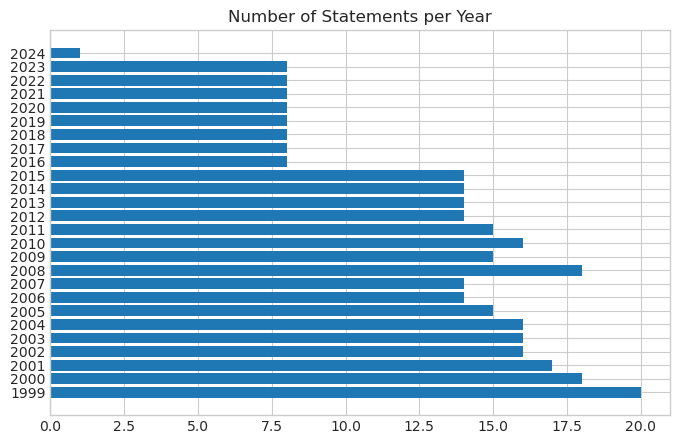

In [709]:
boj_statements_text.index = pd.to_datetime(boj_statements_text.index)
articles_per_year = boj_statements_text.groupby(boj_statements_text.index.year).size()
bar(articles_per_year, title="Number of Statements per Year", sort=False, horizontal=True)

Ce graphique indique que la Banque du Japon (BOJ) a émis un nombre stable de déclarations de politique monétaire annuellement de 2016 à 2023, aligné sur son calendrier de huit réunions par an. Cela suggère une certaine constance dans la communication de la BOJ pendant cette période, ce qui peut être interprété comme une phase de politique monétaire stable ou de routine opérationnelle.

Pour les années précédant 2016 où le nombre de déclarations est plus élevé, cela peut indiquer une période de plus grande volatilité économique ou de changements significatifs dans la politique monétaire qui nécessitaient une communication plus fréquente. Par exemple, la période après la crise financière globale de 2008 jusqu'à 2015 montre un nombre de déclarations élevé, ce qui pourrait correspondre aux efforts de la BOJ pour stabiliser l'économie et atteindre ses objectifs de prix et d'emploi. 

Ce graphique peut aussi refléter l'adaptation de la BOJ à des circonstances économiques changeantes et son engagement à communiquer ses actions de politique monétaire de manière transparente. La réduction du nombre de déclarations après 2015 pourrait donc signifier que la BOJ a trouvé un rythme de communication qui correspond mieux à son approche de politique monétaire durant ces années.

### B. Most words employed

Pour analyser les mots les plus employés, nous utilisons `TfidfVectorizer`, un outil de la bibliothèque scikit-learn, utilisé pour convertir une collection de documents bruts en une matrice de caractéristiques TF-IDF (Term Frequency-Inverse Document Frequency). Il évalue l'importance d'un mot dans un document par rapport à une collection de documents. L'outil ignore les mots courants en anglais (`stop_words="english"`), ne considère que les mots qui apparaissent dans au moins 5 documents (`min_df=5`) et exclut ceux qui sont trop communs, apparaissant dans plus de 80% des documents (`max_df=0.8`). Il analyse également les unigrammes, bigrammes et trigrammes (`ngram_range=(1, 3)`) pour une représentation plus riche du contexte, et se limite aux mots composés d'au moins trois caractères, afin d'éliminer les termes moins pertinents ou trop courts. Cette approche raffinée permet de dégager les termes les plus significatifs, offrant une compréhension plus approfondie des thèmes et sujets prédominants dans les communications de la Banque du Japon.

In [710]:
vectorizer = TfidfVectorizer(
    stop_words="english",
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 3),
    token_pattern=r"\b[a-zA-Z]{3,}\b",
)
X = vectorizer.fit_transform(boj_statements_text["Text"].values)

In [711]:
cols = vectorizer.get_feature_names_out()
print(len(cols))
list(cols)[:10]

9505


['abate',
 'abated',
 'abroad',
 'abroad bank',
 'abroad bank patiently',
 'abroad economic',
 'abroad improvement',
 'abroad improvement overseas',
 'abroad industrial',
 'abroad industrial production']

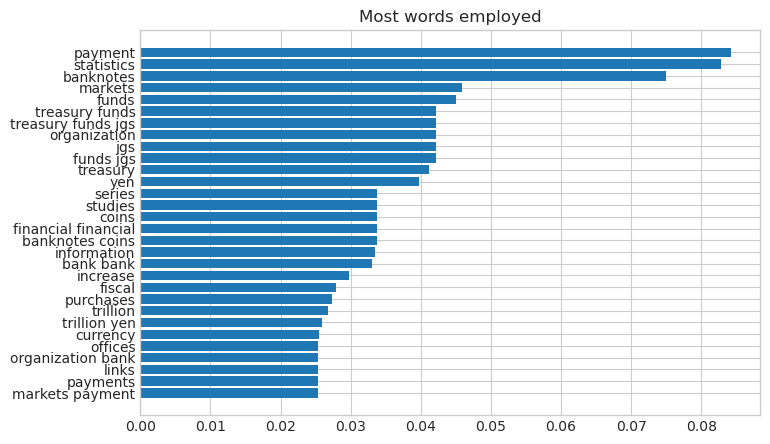

In [712]:
df = pd.DataFrame(X.toarray(), index=boj_statements_text["Text"].index, columns=cols)
bar(df.mean().sort_values(ascending=False).head(30), horizontal=True, title= "Most words employed")

Les termes "payment" et "bank" sont les plus fréquents, ce qui suggère qu'ils sont des sujets centraux ou des thèmes récurrents dans les documents analysés. D'autres termes fréquents incluent "markets", "payments", "links", "organization", "bank", "currency", "trillion yen", "fiscal", "increase", et "information".

Les mots comme "trillion yen" et "fiscal" indiquent que les discussions pourraient être centrées sur des sujets de grande échelle financière, possiblement en relation avec le budget de l'État, les dépenses publiques, ou la masse monétaire. La répétition de mots liés à la monnaie ("yen", "banknotes", "coins") suggère un focus sur les aspects monétaires.

### C. Principal component exploration

Pour décrire la matrice des scores tf idf, nous effectuons d'abord une simple analyse en composantes principales (« PCA ») avec deux modes. (voir cours Sylvain Champonnois)

In [713]:
m = PCA(n_components=2).fit(np.log1p(X.toarray().T))
df = pd.DataFrame(m.components_.T, index=boj_statements_text.index)

Text(0, 0.5, 'PC 1')

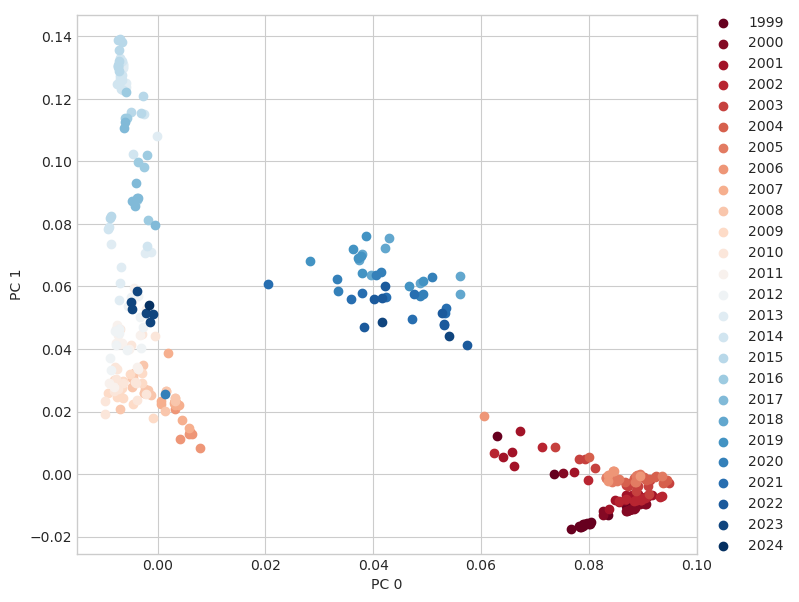

In [714]:
m = PCA(n_components=2).fit(np.log1p(X.toarray().T))
df = pd.DataFrame(m.components_.T, index=boj_statements_text.index)

fig, ax = plt.subplots(1, 1, figsize=(8, 7))
years = [str(y) for y in df.index.year.unique()]
colors = cm.RdBu(np.linspace(0, 1, len(years)))
for i, y in enumerate(years):
    ax.scatter(x=df.loc[y][0], y=df.loc[y][1], color=colors[i])
ax.legend(years, loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xlabel("PC 0")
ax.set_ylabel("PC 1")

De cette analyse en composante principale, nous pouvons noter plusieurs regroupements d'années différents. Sans faire un clustering, nous notons d'une analyse visuelle, trois clusters d'années assez dispersés le long de l'axe 0: 
- le premier tout à gauche en bleu et orange clair comprend les années de 2007 à 2016, les elements de ce cluster sont très dispersés le long de l'axe 1,  ce qui suggère que les données de ces années ont une grande variabilité qui est capturée par PC 1.
- le deuxième cluster au centre en bleu moyen, regroupe les années de 2017 de à 2022.Ces points sont moins dispersés le long de l'axe PC 1 et sont plus concentrés, ce qui pourrait indiquer une période de moindre variabilité par rapport à la première période.
- enfin le troisième cluster tout à droite en rouge et orange, et regroupe les années de 1999 à 2006.

Ces clusters identifiés pourraient refléter des périodes distinctes en termes de contexte financier et de politique monétaire de la Banque du Japon (BoJ).

1. **Premier cluster (2007 à 2016)**: Cette période englobe la crise financière mondiale de 2008, qui a entraîné une intervention importante des banques centrales, y compris la BoJ. La BoJ a adopté des politiques monétaires très accommodantes, notamment des taux d'intérêt très bas et des programmes d'assouplissement quantitatif (quantitative easing, QE) pour stimuler l'économie. La dispersion élevée le long de l'axe PC 1 pourrait refléter les diverses mesures prises pendant cette période, ainsi que les fluctuations économiques importantes dues à la crise et à la reprise subséquente.

2. **Deuxième cluster (2017 à 2022)**: Les années suivantes ont été marquées par une continuation des politiques d'assouplissement, mais avec une certaine normalisation et des tentatives de la BoJ pour stimuler l'inflation qui est restée en deçà de l'objectif de 2 %. La concentration des points et la moindre dispersion pourraient indiquer une période de stabilité relative ou une politique monétaire moins volatile après les turbulences de la crise financière. Cela pourrait également refléter l'impact des politiques de long terme mises en place par la BoJ pour soutenir la croissance économique.

3. **Troisième cluster (1999 à 2006)**: Cette période couvre la fin de la décennie perdue du Japon, une période de stagnation économique dans les années 1990. En réponse, la BoJ a été l'une des premières banques centrales à adopter une politique de taux d'intérêt proches de zéro et à commencer à utiliser des mesures non conventionnelles pour lutter contre la déflation. La dispersion des points dans ce cluster pourrait illustrer la diversité des défis économiques et des réponses politiques de la BoJ à cette époque.

#### Interprétation des axes

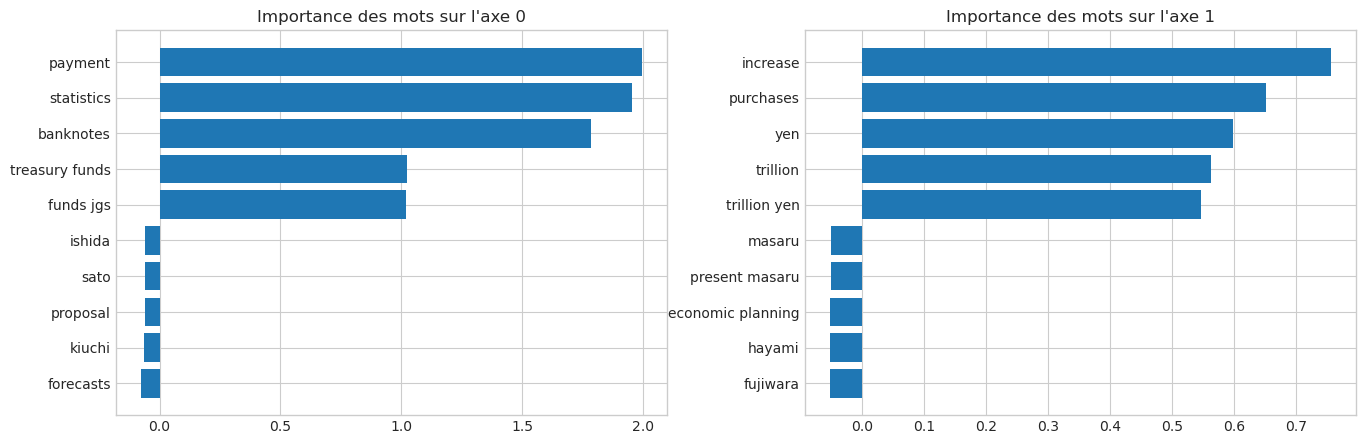

In [715]:
func = lambda x: pd.concat([x.nlargest(), x.sort_values(ascending=False).tail(5)])
W = pd.DataFrame(m.transform(np.log1p(X.toarray().T)), index=cols)

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
plt.subplots_adjust(wspace=0.25)
for i in [0, 1]:
    bar(W[i].pipe(func), horizontal=True, ax=ax[i], title="Importance des mots sur l'axe " + str(i))

- **Axe PC 0 (horizontale)** : Cet axe semble capturer les différences à long terme dans les données. Si nous considérons que cet axe reflète les changements dans la politique monétaire de la Banque du Japon, il pourrait représenter l'évolution des stratégies de politique monétaire au fil des ans. Par exemple, le mouvement vers la droite pourrait indiquer une période de politiques de plus en plus non conventionnelles et agressives, comme l'assouplissement quantitatif et les taux d'intérêt négatifs. La position des clusters suggère que les politiques et les conditions économiques de 1999 à 2006 sont nettement différentes de celles de 2007 à 2016 et de 2017 à 2022.

- **Axe PC 1 (verticale)** : Cet axe semble capturer les différences dans la variabilité annuelle des données. Une grande dispersion le long de cet axe, comme observée pour le premier cluster (2007 à 2016), pourrait indiquer des années de forte volatilité financière ou des réponses politiques variables face à des crises économiques ou à des périodes de récession et de reprise. Une dispersion moindre, comme celle du deuxième cluster (2017 à 2022), pourrait indiquer une période de relative stabilité économique ou une continuité de la politique monétaire.

En se penchant sur le graphique montrant l'importance des mots sur chaque axe, on note que: sur l'axe 0, nous voyons un ensemble de termes tels que "payment", "statistics", "banknotes", qui pourraient être liés aux opérations et aux transactions financières quotidiennes, ainsi qu'à la gestion et à la politique monétaire.

Sur l'axe 1, il y a des mots comme "increase", "purchases", "yen", "trillion", qui semblent être associés à des mesures économiques, probablement reflétant la discussion autour de la taille de l'économie, de la monnaie, et des actions financières telles que les achats ou les investissements

# III. Sentiment analysis

## A. Sentiment in BOJ statements: Loughran-McDonalds dictionary

Dans cette section, nous mesurons le sentiment avec le dictionnaire de sentiment de Loughran-McDonald de deux manières :

- sentiment = (#positif - #négatif)/(#positif + #négatif)
- sentiment = (#positif - #négatif)/(#mots)

Dans le premier cas, les documents courts (avec peu ou pas de mots de sentiment) pourraient conduire à des estimations biaisées.( Source: cours)

In [716]:
X=boj_statements_text["Text"]

In [717]:
lm=load_loughran_mcdonald_dictionary()

loading from external source


In [718]:
lm

,Word,Seq_num,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Syllables,Source
0,AARDVARK,1,354,1.550080e-08,1.422600e-08,3.815486e-06,99,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,3,1.313627e-10,8.653817e-12,9.241714e-09,1,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,9,3.940882e-10,1.169679e-10,5.290465e-08,7,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,29,1.269840e-09,6.654735e-10,1.595100e-07,28,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,8570,3.752595e-07,3.809464e-07,3.529356e-05,1108,0,0,0,0,0,0,0,3,12of12inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86526,ZYGOTE,86529,50,2.189379e-09,8.729336e-10,1.886011e-07,35,0,0,0,0,0,0,0,2,12of12inf
86527,ZYGOTES,86530,1,4.378757e-11,1.809516e-11,1.932446e-08,1,0,0,0,0,0,0,0,2,12of12inf
86528,ZYGOTIC,86531,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,3,12of12inf
86529,ZYMURGIES,86532,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,3,12of12inf


In [719]:
funcs = {
    "negative": lambda x: x.Negative > 0,
    "positive": lambda x: x.Positive > 0,
    "all": lambda x: x.Word.notna(),
}


def get_total_count(X, lm, func):
    m = CountVectorizer(vocabulary=lm.loc[func].Word.str.lower().values)
    return pd.DataFrame(m.fit_transform(X).toarray(), index=X.index).sum(axis=1)


lm_counts = pd.concat({k: get_total_count(X, lm, v) for k, v in funcs.items()}, axis=1)

In [720]:
lm_counts

,negative,positive,all
Date,,,
1999-12-17,9,4,794
1999-11-26,8,4,718
1999-11-12,8,4,753
1999-10-27,8,4,717
1999-10-13,8,4,760
...,...,...,...
2023-06-16,10,12,952
2023-04-28,6,10,619
2023-03-10,15,13,1520


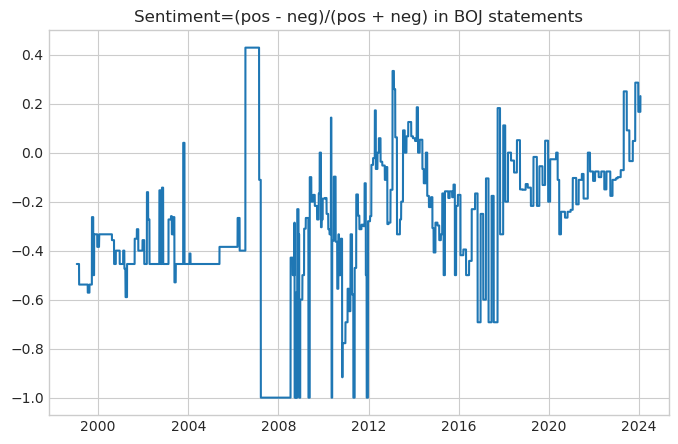

In [721]:
line(
    lm_counts.pipe(lambda x: (x.positive - x.negative) / (x.positive + x.negative))
    .resample("B")
    .last()
    .ffill(),
    legend=False,
    title="Sentiment=(pos - neg)/(pos + neg) in BOJ statements",
)

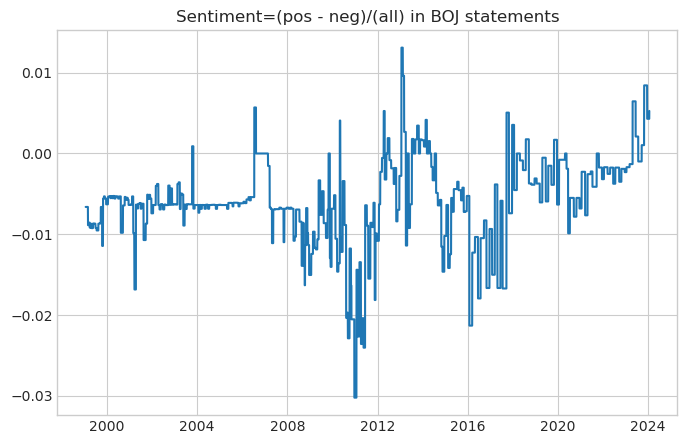

In [722]:
line(
    lm_counts.pipe(lambda x: (x.positive - x.negative) / x["all"])
    .resample("B")
    .last()
    .ffill(),
    legend=False,
    title="Sentiment=(pos - neg)/(all) in BOJ statements",
)

Le graphique montre l'évolution du sentiment (positive - negative)/(positive+negative) au fil du temps, de l'an 2000 à 2024. De ce graphique, on note que:

- Il y a des fluctuations considérables dans le sentiment exprimé dans les déclarations de la BoJ au fil des ans.
- De 2000 jusqu'à environ 2012, le sentiment oscille fréquemment entre positif et négatif, avec des valeurs atteignant jusqu'à -0.6, ce qui suggère des périodes de sentiment fortement négatif.
- Après 2012, les valeurs semblent se stabiliser quelque peu, mais continuent de varier entre légèrement positif et négatif.
À partir de 2020 jusqu'à la fin du graphique en 2024, on observe une tendance à la hausse du sentiment, suggérant une perspective plus positive dans les déclarations de la BoJ.

In [723]:
lm_lexica = {
    "negative": pd.Series(1, lm.loc[lm.Negative > 0].Word.str.lower().values),
    "positive": pd.Series(1, lm.loc[lm.Positive > 0].Word.str.lower().values),
}

In [724]:
show_text(
    boj_statements_text.loc[["2008-08-19", "2008-10-07", "2008-11-21", "2008-12-19"]], lexica=lm_lexica, n=None
)

## B. Sentiment in BOJ statements: supervised learning

Dans cette section, nous faisons de l'apprentissage supervisé pour l'analyse de sentiment en analysant les rendements de marché à différentes dates par les mots contenus dans les documents sortis à ces dates. Pour cela, une chaîne de traitement de données est mise en place pour l'analyse de texte et la modélisation. Le texte est d'abord transformé en une matrice de caractéristiques numériques en utilisant la technique TF-IDF. Les mots sont filtrés pour inclure seulement ceux composés d'au moins trois lettres et pour exclure les mots courants en anglais. Les caractéristiques extraites sont limitées à un ensemble des 300 termes les plus pertinents, sous forme de mots uniques ou de séquences allant jusqu'à trois mots.

Ces caractéristiques servent ensuite à ajuster un modèle de régression Elastic Net, qui combine les atouts de la régression Ridge et Lasso pour améliorer la robustesse du modèle face à des données corrélées et pour effectuer une sélection de caractéristiques implicite. Le modèle est entraîné sur des données dont les indices ont été harmonisés pour s'assurer que seules les observations correspondantes entre les caractéristiques et la variable cible sont prises en compte.

Après l'ajustement du modèle, les coefficients associés à chaque terme sont extraits pour évaluer leur impact sur la variable prédite. Une visualisation de ces coefficients permet d'interpréter l'influence relative de chaque terme dans le modèle, mettant en lumière les mots qui ont le plus de poids dans les prédictions ou les évaluations effectuées par le modèle.

Nous avons pris comme proxy de marché, le Nikkei225, qui est le principal indice de la bourse de Tokyo.

In [725]:
# Download Nikkei 225 Index data from Yahoo Finance
nikkei225 = yf.download("^N225", start="1999-01-01")

# Extract the 'Close' column
nikkei225_close = nikkei225[['Close']]

/opt/mamba/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [726]:
ret=nikkei225_close.pct_change().dropna()

In [727]:
ret

,Close
Date,
1999-01-05,-0.013652
1999-01-06,0.017813
1999-01-07,0.005056
1999-01-08,-0.010693
1999-01-11,-0.001742
...,...
2024-01-29,0.007716
2024-01-30,0.001080
2024-01-31,0.006124


In [728]:
special_days = ["2008-01-22", "2010-05-09", "2020-03-15"]
idx0 = pd.to_datetime(pd.Index(special_days))
idx = boj_statements_text.index.difference(idx0).union(idx0 + BDay(1))
ret_boj = ret.div(ret.ewm(252).std()).loc[ret.index.intersection(idx)]

In [729]:
ret_boj

,Close
1999-01-19,-0.213881
1999-02-25,0.804120
1999-03-12,-0.064937
1999-03-25,1.852409
1999-04-09,0.034343
...,...
2023-07-28,-0.358548
2023-09-22,-0.470143
2023-10-31,0.470061
2023-12-19,1.251256


In [730]:
y = ret_boj["Close"].dropna()
X = boj_statements_text["Text"]

# Identify and resolve duplicate indices in X
if X.index.duplicated().any():
    # Aggregate duplicates - for example, by joining the text of duplicates
    X = X.groupby(X.index).agg(' '.join)

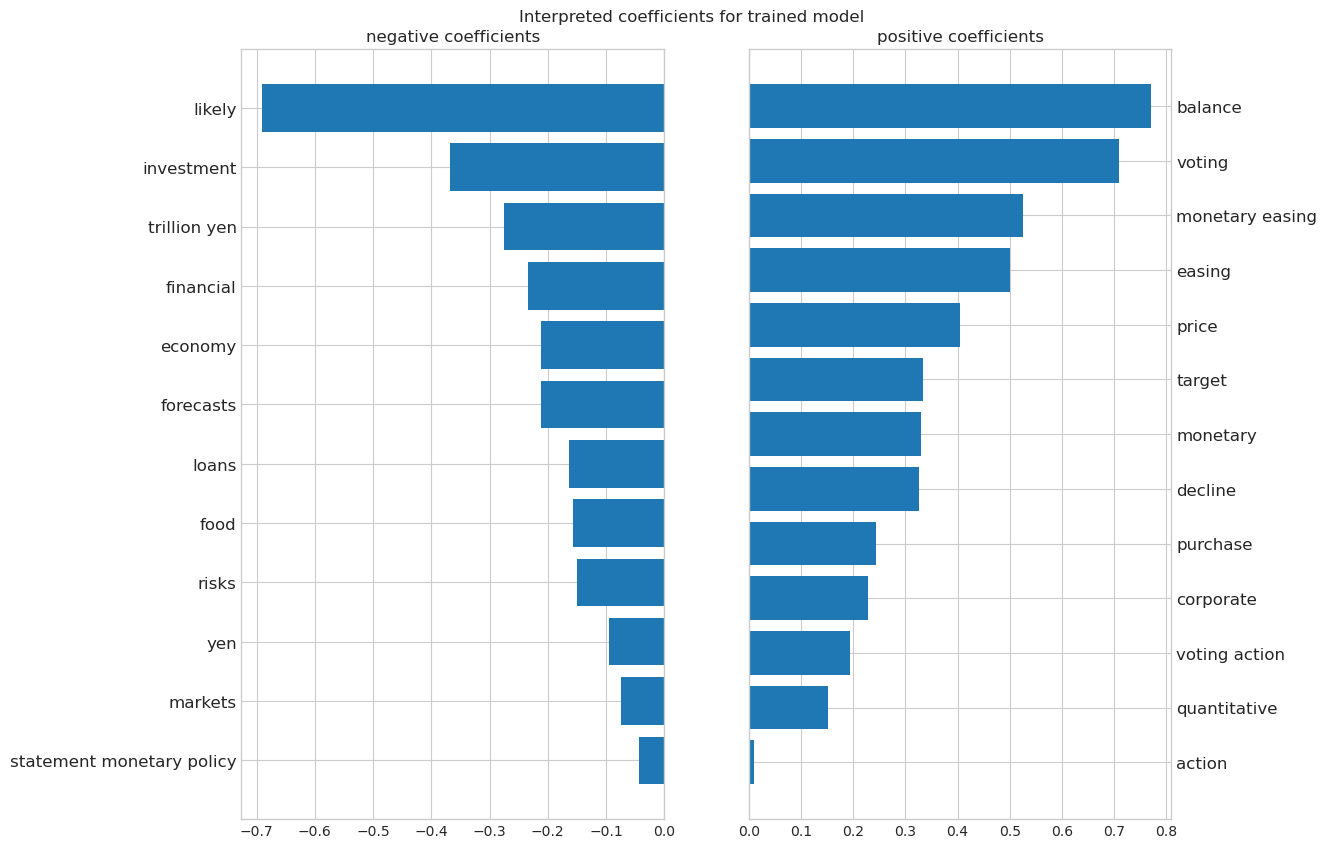

In [731]:
est = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                vocabulary=None,
                ngram_range=(1, 3),
                max_features=300,
                stop_words="english",
                token_pattern=r"\b[a-zA-Z]{3,}\b",
            ),
        ),
        ("reg", ElasticNet(alpha=0.0035)),
    ]
)

idx_ = y.index.intersection(X.index)
X, y = X.loc[idx_], y.loc[idx_]
est.fit(X, y)
vocab_ = pd.Series(est.named_steps["tfidf"].vocabulary_).sort_values().index
interpret_coef = pd.DataFrame(np.transpose(est.named_steps["reg"].coef_), index=vocab_)
coefs_plot(interpret_coef, title="Interpreted coefficients for trained model")

L'interprétation des coefficients dans ce graphique nous donne un aperçu de la façon dont certains termes et concepts sont corrélés avec les mouvements de marché. Les mots clés avec des coefficients positifs indiquent des facteurs ou des sentiments qui soutiennent les rendements du marché, tandis que ceux avec des coefficients négatifs pourraient représenter des risques, des incertitudes ou des conditions défavorables qui pèsent sur les rendements.


- **Coefficients négatifs** : Les termes avec des coefficients négatifs sont associés à une baisse des rendements du marché. Par exemple, "likely" pourrait signifier que lorsque les prévisions ou les attentes (souvent exprimées par le terme "likely") sont discutées, cela pourrait coïncider avec une certaine prudence ou incertitude, conduisant à des rendements inférieurs. Des mots comme "investment" et "financial" pourraient être mentionnés fréquemment dans des contextes où il y a des préoccupations sur les marchés, ce qui pourrait expliquer leur association avec des rendements plus faibles. "Trillion yen" pourrait être référencé dans des discussions sur des interventions ou des mesures fiscales de grande envergure, qui pourraient être perçues comme des réponses à des conditions de marché défavorables.

- **Coefficients positifs** : D'autre part, les termes avec des coefficients positifs sont ceux qui, lorsqu'ils sont mentionnés, tendent à être associés à des rendements de marché plus élevés. "Balance" pourrait faire référence à un équilibre ou une stabilité perçue sur les marchés, ce qui est souvent positivement corrélé avec les rendements. "Monetary easing" et "easing" sont des termes associés aux politiques monétaires accommodantes, qui ont tendance à stimuler l'investissement et à augmenter les prix des actifs, se traduisant par des rendements de marché plus élevés. Les mots comme "purchase" ou "action" pourraient être liés à des activités de marché positives, telles que l'achat d'actifs ou des mesures proactives des entreprises ou des régulateurs qui sont bien reçues par les marchés.

### IV. Sentiment and Market fluctuation

Dans cette section, nous analysons graphiquement le mouvement de marché en fonction du sentiment issu de la BOJ.

In [732]:
sent = lm_counts.copy()

In [733]:
# Calculate the sentiment score
sent['sentiment_score'] = (sent['positive'] - sent['negative']) / (sent['positive'] + sent['negative'])

# Define a function to categorize sentiment into labels
def label_sentiment(row):
    if row['sentiment_score'] > 0:
        return 'positive'
    elif row['sentiment_score'] < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to determine the label
sent['sentiment'] = sent.apply(label_sentiment, axis=1)

In [734]:
sent

,negative,positive,all,sentiment_score,sentiment
Date,,,,,
1999-12-17,9,4,794,-0.384615,negative
1999-11-26,8,4,718,-0.333333,negative
1999-11-12,8,4,753,-0.333333,negative
1999-10-27,8,4,717,-0.333333,negative
1999-10-13,8,4,760,-0.333333,negative
...,...,...,...,...,...
2023-06-16,10,12,952,0.090909,positive
2023-04-28,6,10,619,0.250000,positive
2023-03-10,15,13,1520,-0.071429,negative


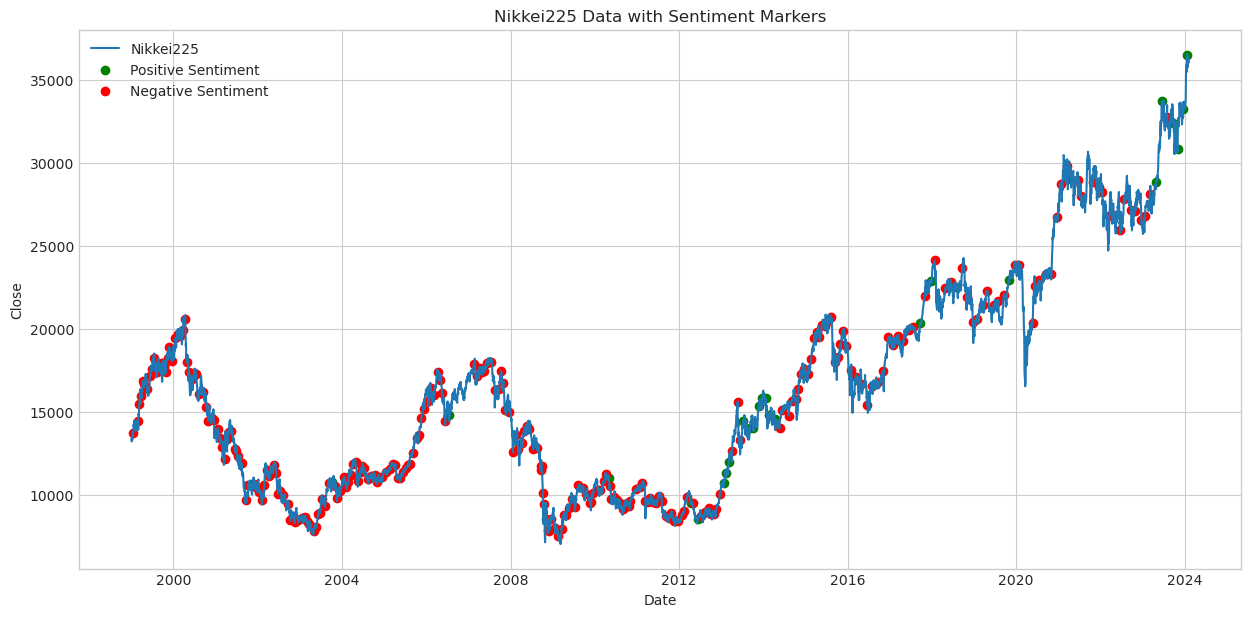

In [735]:
# Plot the time series data
plt.figure(figsize=(15, 7))
plt.plot(nikkei225_close.index, nikkei225_close['Close'], label='Nikkei225')

# Add sentiment markers
# Positive sentiments
positive_dates = sent[sent['sentiment'] == 'positive'].index
positive_scores = nikkei225_close.loc[positive_dates, 'Close']
plt.scatter(positive_dates, positive_scores, color='green', label='Positive Sentiment')

# Negative sentiments
negative_dates = sent[sent['sentiment'] == 'negative'].index
negative_scores = nikkei225_close.loc[negative_dates, 'Close']
plt.scatter(negative_dates, negative_scores, color='red', label='Negative Sentiment')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Nikkei225 Data with Sentiment Markers')
plt.legend()

# Show the plot
plt.show()
